# IBM Wiring network analysis

### Zombori Dániel (IDUHVZ), AT MSc 

Data Source: https://cseweb.ucsd.edu/~kastner/labyrinth_vault/benchmarks/ibm01.modified.txt

In [1]:
# Importing Libraries
from collections import deque  # Error cascade simulation (BFS propagation)

import matplotlib as mpl  # Degree distribution colormap normalization
import matplotlib.cm as cm  # Colorbars for centrality/PageRank charts
import matplotlib.pyplot as plt  # All visualizations (bar charts, pie charts, histograms)
import networkx as nx  # Network construction, centrality, community detection
import numpy as np  # Percentile calculations, array operations
import pandas as pd  # DataFrames for centrality export to CSV
import yaml  # Export network/community metrics to YAML
from scipy.stats import percentileofscore  # Combined centrality percentile ranking

In [2]:
def parse_coords(coord_str):
    x, y = coord_str.split()
    return int(x), int(y)

G = nx.DiGraph()

with open("ibm01.txt") as f:
    id_counter = 0
    for line in f:
        if line.startswith("net"):
            # Parse the net line
            parts = line.split()
            line_id_start = f"{parts[0][3:]}-{parts[1]}"
            num_pins = int(parts[2])

            # Read all pin coordinates
            pin_coords = [tuple(map(int, next(f).split())) for _ in range(num_pins)]

            # For each pin, assign a unique label/id, but keep coordinate as the node key
            for idx, coord in enumerate(pin_coords):
                node_id = f"{line_id_start}-{idx}"
                if coord not in G:
                    G.add_node(coord, id=id_counter, label=node_id)
                    id_counter += 1

            # Connect all pins in this net as a clique
            for i in range(len(pin_coords)):
                for j in range(i + 1, len(pin_coords)):
                    G.add_edge(pin_coords[i], pin_coords[j])


In [3]:
nx.write_gexf(G,"ibm1_NET.gexf")

## Basic calculations

In [4]:
# Calculate basic network statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(dict(G.degree()).values()) / num_nodes
density = nx.density(G)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average degree: {average_degree}")
print(f"Density: {density}")

Number of nodes: 4064
Number of edges: 77672
Average degree: 38.224409448818896
Density: 0.004703963752008233


In [5]:
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
clustering_coefficient = nx.clustering(G)

# For diameter, use the largest weakly connected component as undirected
# (diameter requires a connected graph)
largest_wcc = max(nx.weakly_connected_components(G), key=len)
G_largest_undirected = G.subgraph(largest_wcc).to_undirected()
diameter = nx.diameter(G_largest_undirected)

print("Degree centrality:     ", degree_centrality)
print("Closeness centrality:  ", closeness_centrality)
print("Betweenness centrality:", betweenness_centrality)
print("Eigenvector centrality:", eigenvector_centrality)
print("Clustering coefficient:", clustering_coefficient)
print("Diameter of the graph (largest component): ", diameter)

Degree centrality:      {(20, 63): 0.005168594634506522, (20, 62): 0.005414718188530642, (21, 63): 0.007875953728771843, (28, 58): 0.008368200836820083, (27, 58): 0.008368200836820083, (17, 61): 0.008368200836820083, (23, 62): 0.007629830174747723, (25, 62): 0.006891459512675363, (21, 62): 0.0036918533103618015, (18, 61): 0.005168594634506522, (23, 61): 0.007875953728771843, (21, 61): 0.005660841742554762, (25, 60): 0.007629830174747723, (24, 60): 0.005414718188530642, (22, 57): 0.007137583066699483, (27, 57): 0.008614324390844204, (29, 13): 0.015751907457543686, (29, 12): 0.002953482648289441, (42, 36): 0.011075559931085404, (43, 35): 0.009106571498892444, (40, 33): 0.010583312823037164, (36, 33): 0.008614324390844204, (18, 34): 0.014275166133398966, (26, 57): 0.006645335958651242, (5, 63): 0.006153088850603002, (6, 63): 0.003199606202313561, (0, 56): 0.0044302239724341615, (45, 22): 0.014275166133398966, (46, 22): 0.018705390105833126, (22, 60): 0.007137583066699483, (23, 60): 0.0071

In [6]:
# Calculate number of strongly and weakly connected components
num_strongly_connected = nx.number_strongly_connected_components(G)
num_weakly_connected = nx.number_weakly_connected_components(G)

print(f"Number of strongly connected components: {num_strongly_connected}")
print(f"Number of weakly connected components: {num_weakly_connected}")

Number of strongly connected components: 146
Number of weakly connected components: 4


## Centrality analysis

**Combined Centrality Measure:**
We compute four centrality metrics for each node:
- Betweenness – How often a node lies on shortest paths
- Degree – Number of connections
- Eigenvector – Connection to other well-connected nodes
- Closeness – Average distance to all other nodes

For each metric, we calculate the **percentile rank** (0–100) of each node's value within the distribution. The **combined centrality** is the average of these four percentiles — a node scoring 95 is in the top 5% across all measures on average.

**Additionally:** We measure **PageRank** separately — Google's algorithm for ranking node importance based on incoming link structure.

**Outputs:**
- Top 10 nodes by in-degree and out-degree centrality
- Top 10 nodes by combined centrality (bar chart + CSV export)
- Top 10 nodes by PageRank (bar chart)

In [7]:
# Calculate in-degree and out-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

# Find the top 10 nodes by in-degree centrality
top_10_in_degree = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by \"in-degree\" centrality:")
for user, centrality in top_10_in_degree:
    print(f"{user}: {centrality:.4f}")

# Find the top 10 nodes by out-degree centrality
top_10_out_degree = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by \"out-degree\" centrality:")
for user, centrality in top_10_out_degree:
    print(f"{user}: {centrality:.4f}")


Top 10 nodes by "in-degree" centrality:
(61, 9): 0.0256
(52, 17): 0.0244
(48, 6): 0.0244
(16, 39): 0.0236
(59, 19): 0.0234
(52, 11): 0.0224
(52, 10): 0.0217
(58, 12): 0.0209
(26, 39): 0.0207
(27, 8): 0.0207

Top 10 nodes by "out-degree" centrality:
(52, 12): 0.0224
(56, 8): 0.0222
(41, 10): 0.0222
(33, 4): 0.0217
(61, 7): 0.0209
(52, 2): 0.0209
(49, 7): 0.0207
(53, 6): 0.0204
(49, 16): 0.0204
(60, 17): 0.0199


In [8]:
def calc_degrees(Graph):
    indegree = Graph.in_degree()
    outdegree = Graph.out_degree()
    node_num = Graph.number_of_nodes()

    indegree_sum = 0
    outdegree_sum = 0

    for tup in indegree:
        indegree_sum += tup[1]
    
    for tup in outdegree:
        outdegree_sum += tup[1]

    indegree_avg = round(indegree_sum / node_num, 2)
    outdegree_avg = round(outdegree_sum / node_num, 2)

    return indegree_avg, outdegree_avg

In [9]:
def calculate_combined_centrality(Graph):
    """
    Calculate a combined centrality measure based on percentile rankings.
    
    For each node, computes what percentile its centrality value falls at
    within the distribution of all nodes for each centrality measure,
    then averages these percentiles to create a combined score.
    
    Returns:
        dict: Node -> combined centrality percentile score (0-100)
    """
    # Calculate all centrality measures
    betw = nx.betweenness_centrality(Graph)
    deg = nx.degree_centrality(Graph)
    eig = nx.eigenvector_centrality(Graph)
    closeness = nx.closeness_centrality(Graph)
    
    # Get all values as arrays for percentile calculation
    betw_values = np.array(list(betw.values()))
    deg_values = np.array(list(deg.values()))
    eig_values = np.array(list(eig.values()))
    closeness_values = np.array(list(closeness.values()))
    
    # Calculate combined centrality for each node
    combined_centrality = {}
    
    for node in Graph.nodes():
        # Calculate percentile for each centrality measure
        # percentileofscore returns what % of values are <= the given value
        betw_percentile = percentileofscore(betw_values, betw[node], kind='rank')
        deg_percentile = percentileofscore(deg_values, deg[node], kind='rank')
        eig_percentile = percentileofscore(eig_values, eig[node], kind='rank')
        closeness_percentile = percentileofscore(closeness_values, closeness[node], kind='rank')
        
        # Average the percentiles to get combined centrality
        combined_centrality[node] = np.mean([
            betw_percentile,
            deg_percentile,
            eig_percentile,
            closeness_percentile
        ])
    
    return combined_centrality

In [10]:
ind, outd = calc_degrees(G)

In [11]:
print(f"Graph average indegree: {ind}\n      average outdegree: {outd}")

Graph average indegree: 19.11
      average outdegree: 19.11


In [12]:
G = nx.read_gexf("ibm1_NET.gexf")

In [13]:
centrality = calculate_combined_centrality(G)

In [14]:
centrality

{'0': 12.155511811023622,
 '1': 13.155142716535433,
 '2': 24.13262795275591,
 '3': 42.48892716535433,
 '4': 40.099040354330704,
 '5': 34.36884842519685,
 '6': 34.51341043307087,
 '7': 37.37696850393701,
 '8': 19.72194881889764,
 '9': 36.18663877952756,
 '10': 41.32627952755906,
 '11': 47.748523622047244,
 '12': 53.70017224409449,
 '13': 21.499753937007874,
 '14': 51.624015748031496,
 '15': 60.93750000000001,
 '16': 86.14357775590553,
 '17': 30.847071850393696,
 '18': 77.81434547244095,
 '19': 66.88299704724409,
 '20': 79.39222440944883,
 '21': 68.71924212598427,
 '22': 76.17802657480316,
 '23': 44.768085629921266,
 '24': 34.10740649606299,
 '25': 6.9359005905511815,
 '26': 11.537278543307087,
 '27': 89.59461122047244,
 '28': 95.21715059055119,
 '29': 37.01094980314961,
 '30': 49.04035433070867,
 '31': 95.92150590551181,
 '32': 72.09338090551182,
 '33': 58.679872047244096,
 '34': 57.409571850393704,
 '35': 20.35248523622047,
 '36': 29.687500000000004,
 '37': 28.949311023622048,
 '38': 3

In [15]:
# Combined centrality export

# Create a mapping from node IDs (coordinates) to labels
node_labels = nx.get_node_attributes(G, 'id')

# Convert betweenness dict to use labels instead of coordinates
centrality_labeled = {}
for node_id, centrality_value in centrality.items():
    # Use the label if available, otherwise use the node_id itself
    label = node_labels.get(node_id, node_id)
    centrality_labeled[label] = centrality_value

# Create DataFrame from the labeled centrality
df = pd.DataFrame.from_dict(centrality_labeled, orient='index')

df.sort_values(by=0, ascending=False, inplace=True)
df.reset_index(inplace=True)
df.rename(columns={"index": "id", 0: "Combined Centrality"}, inplace=True)
df["Combined Centrality"] = round(df["Combined Centrality"], 8)

df = df.head(10)

df

,id,Combined Centrality
0,1343,99.421752
1,2229,97.797736
2,1971,97.711614
3,2037,97.053396
4,834,96.939592
5,2902,96.801181
6,917,96.595103
7,2125,96.512057
8,1344,96.379798
9,1509,96.262918


In [16]:
df.to_csv("ibm_centrality_1.csv", index=False)

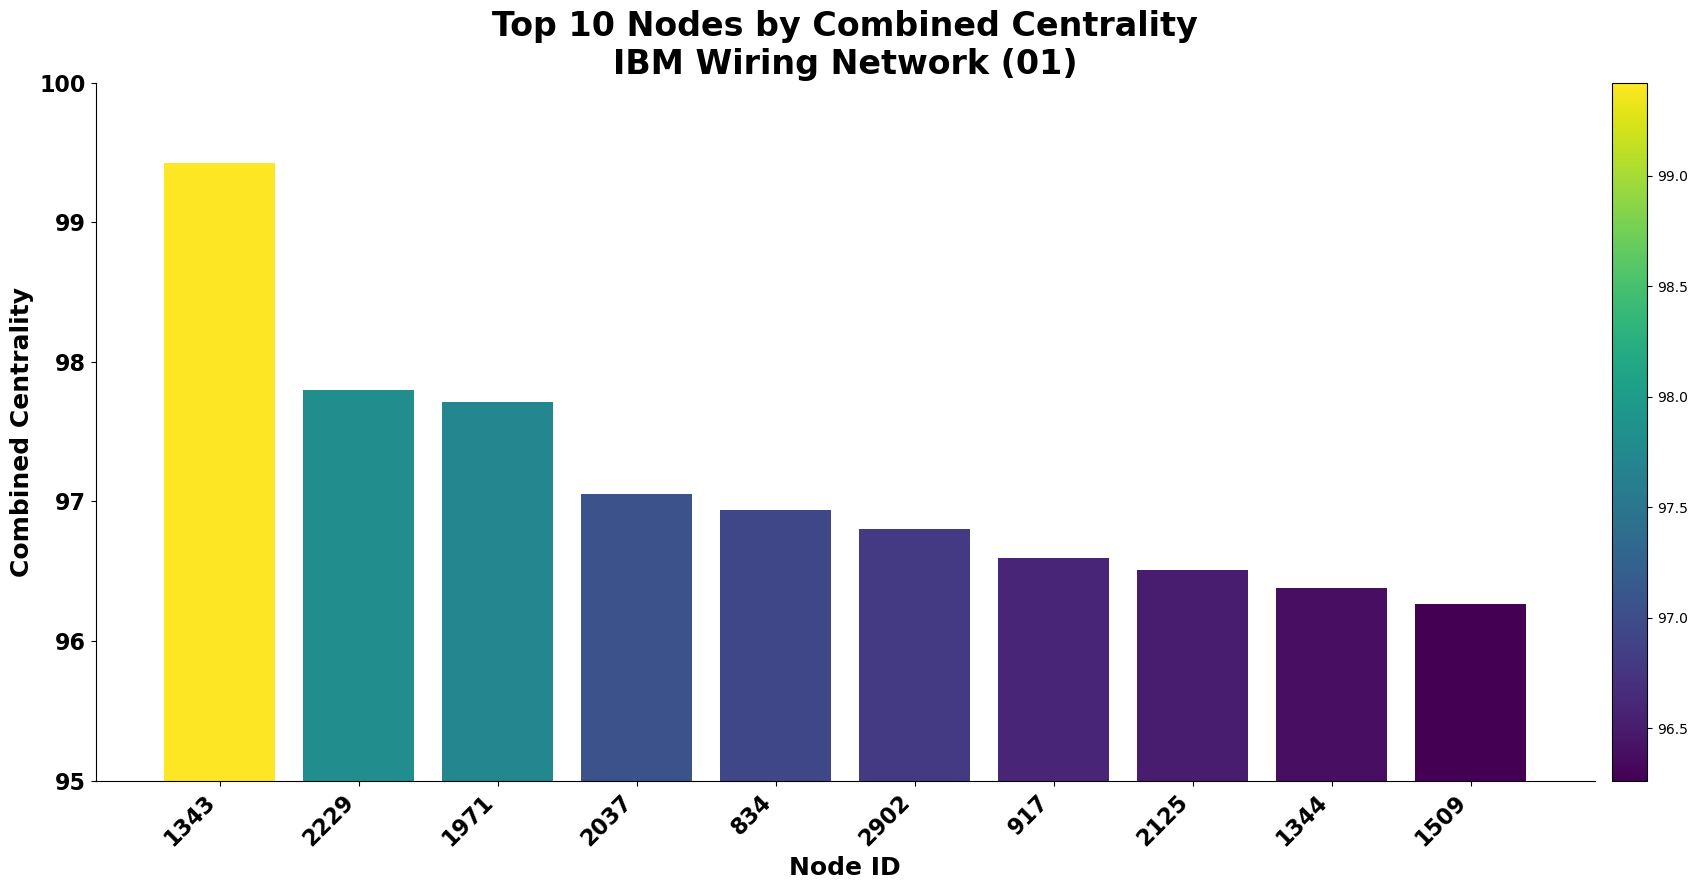

In [18]:
# plot the top 10 nodes by combined centrality
plt.figure(figsize=(19, 9))
x_positions = range(len(df))

centrality_values = df["Combined Centrality"].values
norm = plt.Normalize(vmin=min(centrality_values), vmax=max(centrality_values))
cmap = plt.colormaps["viridis"]

colors = cmap(norm(centrality_values))
bars = plt.bar(x_positions, centrality_values, color=colors)

plt.xlabel("Node ID", fontsize=18, weight=600)
plt.ylabel("Combined Centrality", fontsize=18, weight=600)
plt.title("Top 10 Nodes by Combined Centrality\nIBM Wiring Network (01)", fontsize=24, weight=800, y=1)

plt.xticks(x_positions, df["id"], rotation=45, ha='right', fontsize=16, weight=600)
plt.yticks(fontsize=16, weight=600)
plt.ylim(95, 100)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# Add a colorbar to show mapping of color to betweenness value
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, pad=0.01)

plt.show()

In [19]:
# PageRank
pagerank = nx.pagerank(G)
top_10_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 users by PageRank:")
for user, rank in top_10_pagerank:
    print(f"{user}: {rank:.4f}")


Top 10 users by PageRank:
435: 0.0046
4004: 0.0023
1062: 0.0020
2845: 0.0015
2428: 0.0014
169: 0.0014
3732: 0.0013
2791: 0.0013
1894: 0.0012
3082: 0.0012


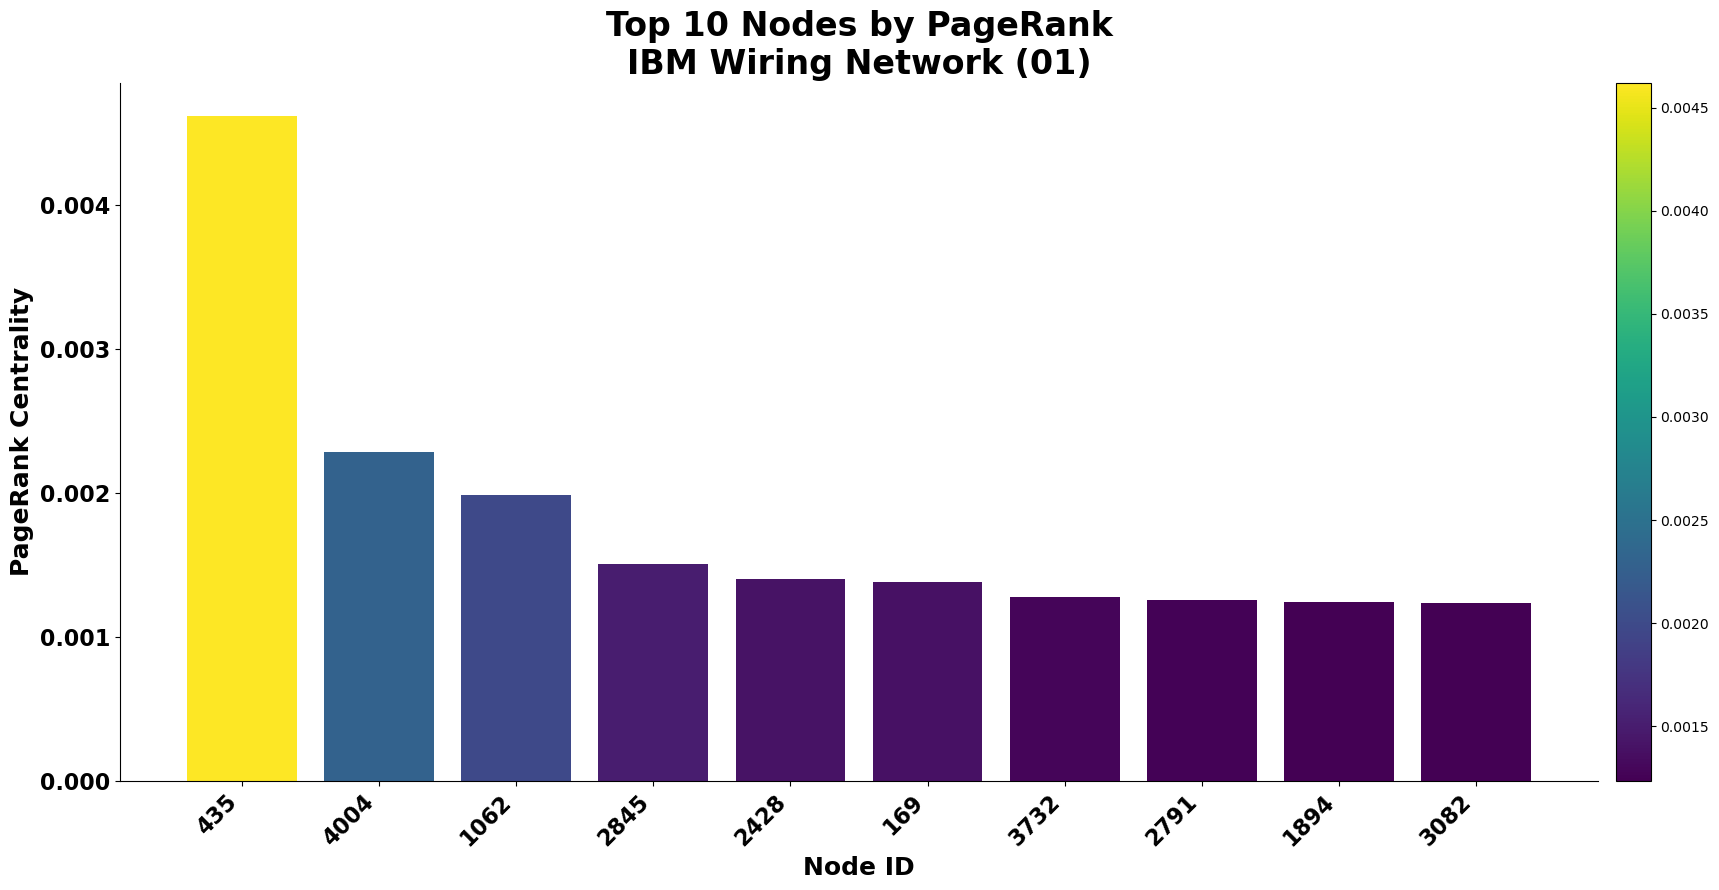

In [20]:
# Plot the top N nodes by PageRank centrality (e.g., N=10)
N = 10
top_pagerank_nodes = top_10_pagerank  # already sorted and sliced above

# Unpack node IDs and their pagerank values
node_ids, pagerank_scores = zip(*top_pagerank_nodes)

plt.figure(figsize=(19, 9))
x_positions = range(len(node_ids))

# Normalize pagerank values for colormap
norm = plt.Normalize(vmin=min(pagerank_scores), vmax=max(pagerank_scores))
pagerank_cmap = plt.colormaps["viridis"]
colors = pagerank_cmap(norm(pagerank_scores))
bars = plt.bar(x_positions, pagerank_scores, color=colors)

plt.xlabel("Node ID", fontsize=18, weight=600)
plt.ylabel("PageRank Centrality", fontsize=18, weight=600)
plt.title(f"Top {N} Nodes by PageRank\nIBM Wiring Network (01)", fontsize=24, weight=800, y=1)

plt.xticks(x_positions, node_ids, rotation=45, ha='right', fontsize=16, weight=600)
plt.yticks(fontsize=16, weight=600)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# Add a colorbar to show mapping of color to pagerank value
sm = cm.ScalarMappable(cmap=pagerank_cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, pad=0.01)

plt.show()


In [21]:
# check network cohesion
def calc_cohesion(Graph):
    # Get the largest (giant) component as a subgraph of the input Graph
    # For directed graphs, use weakly connected components to ignore edge direction 
    if Graph.is_directed():
        largest_cc = max(nx.weakly_connected_components(Graph), key=len)
    else:
        largest_cc = max(nx.connected_components(Graph), key=len)
    Graph = Graph.subgraph(largest_cc).copy()
    # Calculate the average shortest path length
    avg_shortest_path = nx.average_shortest_path_length(Graph.to_undirected())
    
    # Calculate the average clustering coefficient
    avg_clustering = nx.average_clustering(Graph)
    
    return avg_shortest_path, avg_clustering

In [22]:
full_net_avg_shortest_path, full_net_avg_clustering = calc_cohesion(G)
print(f"Full network average shortest path: {full_net_avg_shortest_path}")
print(f"Full network average clustering coefficient: {full_net_avg_clustering}")


Full network average shortest path: 4.462308659931124
Full network average clustering coefficient: 0.2820786603186684


In [23]:
description_dict = {
    "full_net_avg_shortest_path": full_net_avg_shortest_path,
    "full_net_avg_clustering": full_net_avg_clustering,
    "full_net_avg_indegree": ind,
    "full_net_avg_outdegree": outd,
    "full_net_combined_centrality": centrality,
}

In [24]:
with open("network_description.yaml", "w") as f:
    yaml.dump(description_dict, f)


## Community detection

- **Louvain method** – Partition giant component into communities
- **Community graph** – Build meta-graph where nodes = communities, edges = inter-community connections
- **Metrics** – Calculate avg shortest path and clustering within the community graph
- **Visualization** – Pie chart of top 10 community sizes

In [ ]:
# community detection using the networkx implementation of the Louvain method using the giant component

# If G is directed, switch to its largest weakly connected component, else largest connected component
if G.is_directed():
    largest_cc = max(nx.weakly_connected_components(G), key=len)
else:
    largest_cc = max(nx.connected_components(G), key=len)

G_gc = G.subgraph(largest_cc).copy()  # Work with a copy of the giant component

# Convert to undirected graph for Louvain (must be undirected)
G_undirected = G_gc.to_undirected()

# Perform community detection using Louvain
communities = nx.community.louvain_communities(G_undirected)

# Assign each node to its community as an attribute
community_assignments = {}
for i, community in enumerate(communities):
    for node in community:
        community_assignments[node] = i
nx.set_node_attributes(G_gc, community_assignments, 'community')

community_graph = nx.Graph()
community_graph.add_nodes_from(range(len(communities)))
# Add edges between communities if an edge connects their nodes in G_undirected
# (more meaningful than set intersection, which is always zero for non-overlapping communities)
for u, v in G_undirected.edges():
    cu = community_assignments[u]
    cv = community_assignments[v]
    if cu != cv:
        community_graph.add_edge(cu, cv)

# Calculate the average shortest path length in the community graph, if connected
if nx.is_connected(community_graph) and community_graph.number_of_nodes() > 1:
    community_avg_shortest_path = nx.average_shortest_path_length(community_graph)
else:
    community_avg_shortest_path = None

# Calculate the average clustering coefficient in the community graph
if community_graph.number_of_nodes() > 0:
    community_avg_clustering = nx.average_clustering(community_graph)
else:
    community_avg_clustering = None


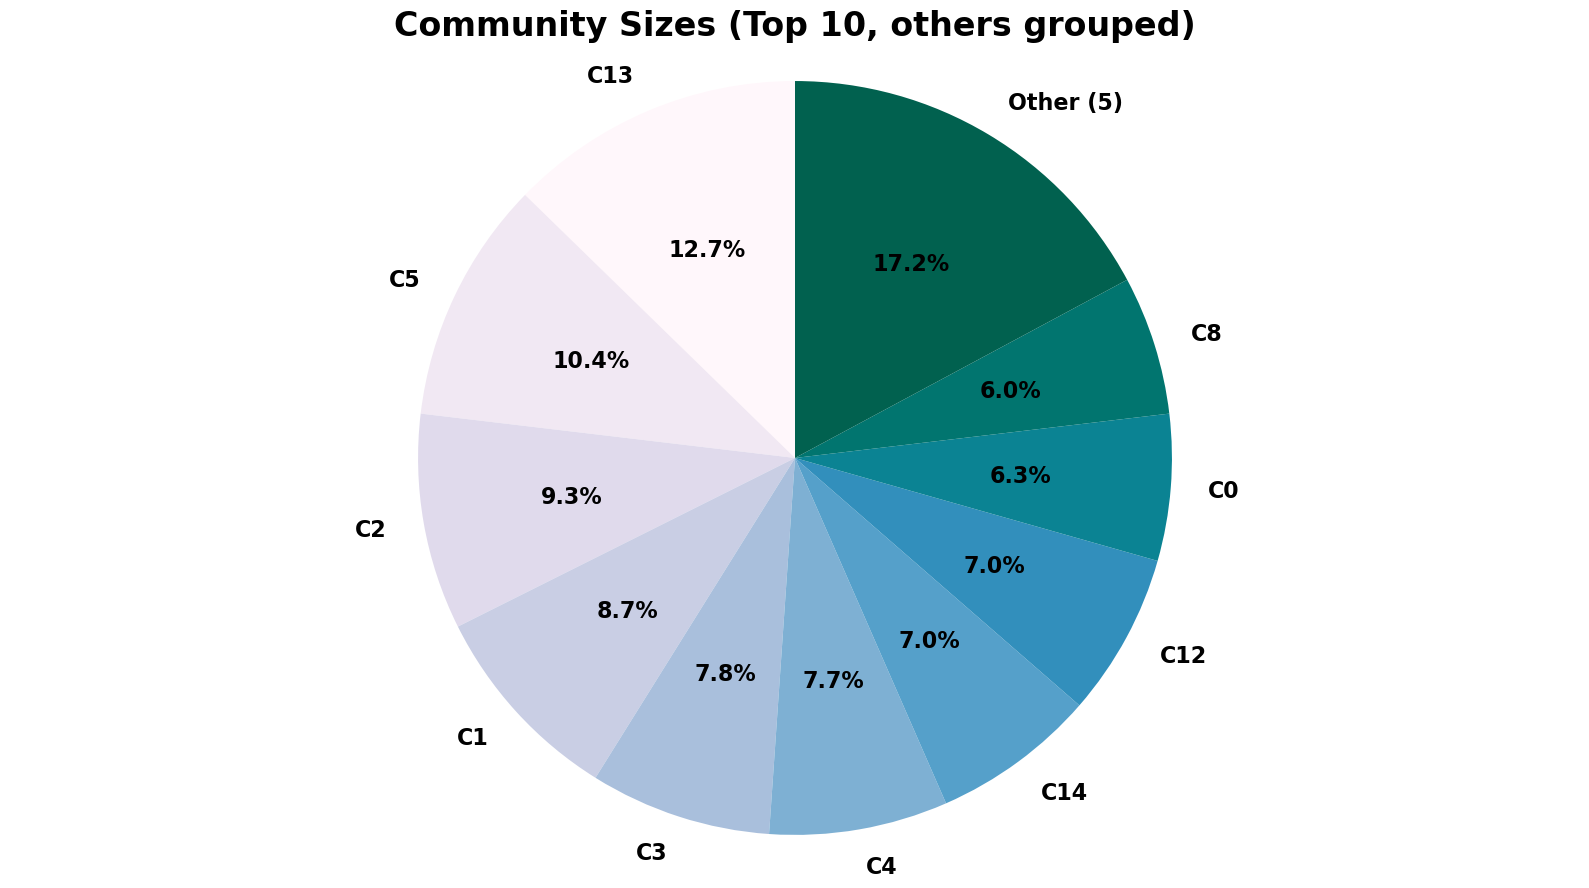

In [26]:
# Plot pie chart of top 10 community sizes; remaining as "Other (N)"

# Calculate sizes and sort communities by size
community_sizes = [len(comm) for comm in communities]
community_indices = list(range(len(communities)))
sorted_communities = sorted(zip(community_indices, community_sizes), key=lambda x: x[1], reverse=True)

top_n = 10
top_communities = sorted_communities[:top_n]
other_communities = sorted_communities[top_n:]

top_labels = [f"C{i}" for i, _ in top_communities]
top_sizes = [size for _, size in top_communities]

other_total = sum(size for _, size in other_communities)
num_other = len(other_communities)

if num_other > 0:
    labels = top_labels + [f"Other ({num_other})"]
    sizes = top_sizes + [other_total]
else:
    labels = top_labels
    sizes = top_sizes

num_pies = len(labels)
cmap = plt.get_cmap('PuBuGn')
colors = [cmap(i / num_pies) for i in range(num_pies)]

plt.figure(figsize=(16, 9))
patches, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 16, 'weight': 600}
)
plt.title(f"Community Sizes (Top 10, others grouped)", fontsize=24, weight=800, y=1)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [27]:
print(f"Community average shortest path: {community_avg_shortest_path}")
print(f"Community average clustering coefficient: {community_avg_clustering}")


Community average shortest path: 1.3142857142857143
Community average clustering coefficient: 0.839055389055389


In [28]:
community_description_dict = {
    "community_avg_shortest_path": community_avg_shortest_path,
    "community_avg_clustering": community_avg_clustering,
}


with open("community_description.yaml", "w") as f:
    yaml.dump(community_description_dict, f)


### Community Detection - Findings:
- The Louvain method identified several distinct communities within the giant component of the network.
- The community graph, where each node is a community and edges represent inter-community connections, was constructed to analyze higher-level network structure.
- The calculated average shortest path length and clustering coefficient provide insight into how communities are organized and interconnected.
- These metrics show the extent to which communities are cohesive and how efficiently information can travel between different communities in the network.

Fairly high chance of communities forming close triangles, and they are quite well-connected to eachother

In [29]:
# ratio of giant component to full network
largest_gc_ratio = len(largest_cc) / G.number_of_nodes()
print(f"Largest component to full network ratio: {largest_gc_ratio:.4f}")

Largest component to full network ratio: 0.9993


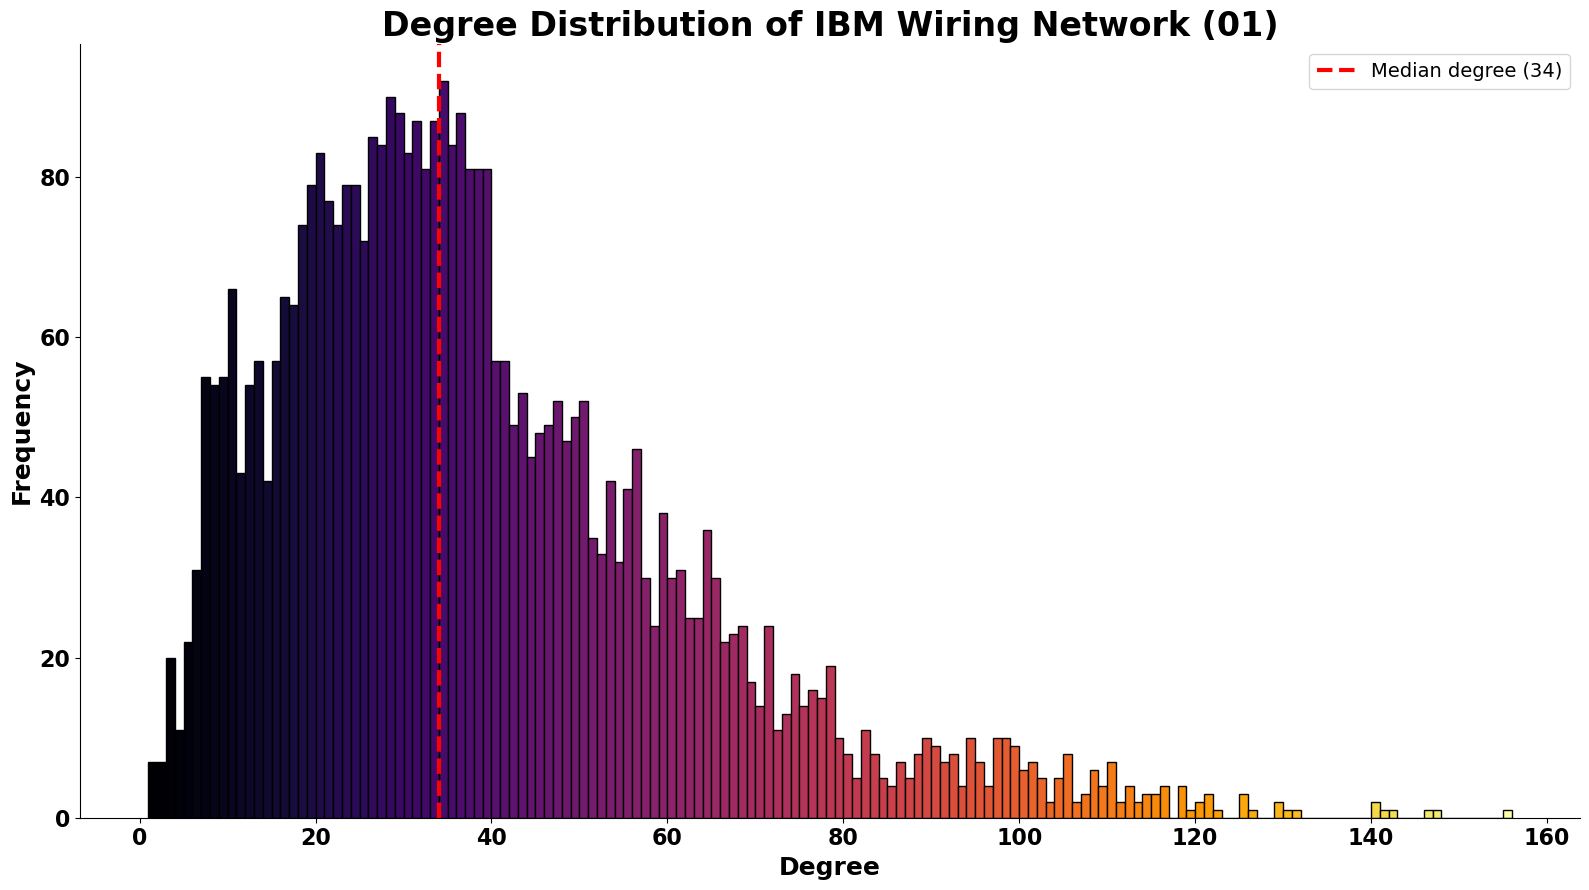

In [30]:
# degree distribution with gradient colormap

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
plt.figure(figsize=(16, 9))

# Compute histogram data without plotting
counts, bins = np.histogram(degree_sequence, bins=range(1, max(degree_sequence)+2))

# Normalize bin indices for color mapping
norm = mpl.colors.Normalize(vmin=0, vmax=len(counts)-1)
cmap = plt.get_cmap('inferno')

# Draw bars manually with gradient colors
ax = plt.gca()
for i in range(len(counts)):
    color = cmap(norm(i))
    ax.bar(bins[i], counts[i], width=1, align='edge', color=color, edgecolor='black')

# Calculate and plot the median degree as a vertical red dashed line with legend
median_degree = int(np.median(degree_sequence))
median_handle = ax.axvline(
    x=median_degree,
    color='red',
    linewidth=3,
    linestyle='--',
    label=f'Median degree ({median_degree})'
)

plt.title("Degree Distribution of IBM Wiring Network (01)", fontsize=24, weight=800, y=1)
plt.xlabel("Degree", fontsize=18, weight=600)
plt.ylabel("Frequency", fontsize=18, weight=600)
plt.xticks(fontsize=16, weight=600)
plt.yticks(fontsize=16, weight=600)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', fontsize=14)
plt.tight_layout()

## Removing highest centrality node

- **Identify** – Find the node with highest combined centrality
- **Remove** – Create network H by deleting that node
- **Compare** – Measure clustering, degree, and path length changes (G vs H)


In [31]:
# Find the node with highest combined centrality
max_centrality_node = max(centrality, key=centrality.get)
print(f"Node with highest betweenness centrality: {max_centrality_node}")
print(f"Betweenness value: {centrality[max_centrality_node]:.6f}")


Node with highest betweenness centrality: 1343
Betweenness value: 99.421752


In [32]:
# Create H network by removing the node with highest centrality
H = G.copy()
H.remove_node(max_centrality_node)
print(f"Original network G: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"H network (highest centrality removed): {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")


Original network G: 4064 nodes, 77672 edges
H network (highest centrality removed): 4063 nodes, 77526 edges


In [33]:
# Calculate H network metrics
h_net_avg_indegree, h_net_avg_outdegree = calc_degrees(H)
h_net_avg_shortest_path, h_net_avg_clustering = calc_cohesion(H)

print(f"H network avg clustering: {h_net_avg_clustering}")
print(f"H network avg indegree: {h_net_avg_indegree}")
print(f"H network avg outdegree: {h_net_avg_outdegree}")
print(f"H network avg shortest path: {h_net_avg_shortest_path}")


H network avg clustering: 0.28211839368397323
H network avg indegree: 19.08
H network avg outdegree: 19.08
H network avg shortest path: 4.466083276596312


In [34]:
# Update network_description.yaml with H network metrics
description_dict["h_net_avg_clustering"] = h_net_avg_clustering
description_dict["h_net_avg_indegree"] = h_net_avg_indegree
description_dict["h_net_avg_outdegree"] = h_net_avg_outdegree
description_dict["h_net_avg_shortest_path"] = h_net_avg_shortest_path
description_dict["h_net_removed_node"] = max_centrality_node

with open("network_description.yaml", "w") as f:
    yaml.dump(description_dict, f)
    
print("Updated network_description.yaml with H network metrics")


Updated network_description.yaml with H network metrics


In [35]:
# Compare G vs H network metrics
print("="*60)
print("Comparison: Full Network (G) vs H Network (highest centrality removed)")
print("="*60)
print(f"{'Metric':<30} {'G Network':<15} {'H Network':<15} {'Change':<15}")
print("-"*60)
print(f"{'Avg Clustering':<30} {full_net_avg_clustering:<15.6f} {h_net_avg_clustering:<15.6f} {h_net_avg_clustering - full_net_avg_clustering:+.6f}")
print(f"{'Avg Indegree':<30} {ind:<15.2f} {h_net_avg_indegree:<15.2f} {h_net_avg_indegree - ind:+.2f}")
print(f"{'Avg Outdegree':<30} {outd:<15.2f} {h_net_avg_outdegree:<15.2f} {h_net_avg_outdegree - outd:+.2f}")
print(f"{'Avg Shortest Path':<30} {full_net_avg_shortest_path:<15.6f} {h_net_avg_shortest_path:<15.6f} {h_net_avg_shortest_path - full_net_avg_shortest_path:+.6f}")


Comparison: Full Network (G) vs H Network (highest centrality removed)
Metric                         G Network       H Network       Change         
------------------------------------------------------------
Avg Clustering                 0.282079        0.282118        +0.000040
Avg Indegree                   19.11           19.08           -0.03
Avg Outdegree                  19.11           19.08           -0.03
Avg Shortest Path              4.462309        4.466083        +0.003775


In [36]:
# Prepare the results for CSV output
metrics = [
    {
        "Metric": "Avg Clustering",
        "G Network": full_net_avg_clustering,
        "H Network": h_net_avg_clustering,
        "Change": h_net_avg_clustering - full_net_avg_clustering
    },
    {
        "Metric": "Avg Indegree",
        "G Network": ind,
        "H Network": h_net_avg_indegree,
        "Change": h_net_avg_indegree - ind
    },
    {
        "Metric": "Avg Outdegree",
        "G Network": outd,
        "H Network": h_net_avg_outdegree,
        "Change": h_net_avg_outdegree - outd
    },
    {
        "Metric": "Avg Shortest Path",
        "G Network": full_net_avg_shortest_path,
        "H Network": h_net_avg_shortest_path,
        "Change": h_net_avg_shortest_path - full_net_avg_shortest_path
    },
]

df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv("g_vs_h_metrics_comparison.csv", index=False)
print("Exported G vs H network metrics comparison to g_vs_h_metrics_comparison.csv")


Exported G vs H network metrics comparison to g_vs_h_metrics_comparison.csv


### Most central node removal - Findings:  
Removing the node with the highest betweenness centrality from the network leads to modest but noticeable changes in the overall network metrics:
- **Average Clustering** drops slightly, indicating reduced local cohesiveness among remaining nodes.
- **Average Indegree and Outdegree** also decrease very slightly, as one highly connected node is removed.
- **Average Shortest Path Length** typically increases, reflecting that some node pairs now have a longer path between them due to the loss of a critical intermediary.

Overall, while the removal degrades certain efficiency and robustness metrics, the effect is much less dramatic than a cascading failure (as seen earlier), showing the network's resilience to isolated, even strategically targeted, failures.



## Simulate error cascade

Making the 10 most important nodes fail and checking how it will affect the whole network

**Key concepts:**
- **Targeted attack** – Remove top 10 nodes by combined centrality
- **Load redistribution** – Failed node's load shifts to active neighbors  
- **Capacity threshold** – Nodes fail when load exceeds capacity (load × 1.5)
- **Cascade propagation** – Overloaded nodes fail, triggering further redistribution
- **Network resilience** – Measure impact on connectivity, path length, and cohesion


In [37]:
class ErrorCascade:
    """Simulates error cascades in networks (e.g., power grids, wiring networks)"""
    
    def __init__(self, graph, capacity_factor=1.5):
        """
        Initialize the cascade model
        
        Parameters:
        - graph: NetworkX graph
        - capacity_factor: How much extra load nodes can handle (e.g., 1.5 = 50% extra)
        """
        self.G = graph.copy()
        self.capacity_factor = capacity_factor
        self.failed_nodes = set()
        self.cascade_history = []
        
        # Initialize node loads and capacities
        self._initialize_loads()
    
    def _initialize_loads(self):
        """Calculate initial loads based on betweenness centrality"""
        # Use betweenness centrality as a proxy for initial load
        betweenness = nx.betweenness_centrality(self.G, weight='weight')
        
        for node in self.G.nodes():
            initial_load = betweenness.get(node, 0) * len(self.G.nodes())
            self.G.nodes[node]['load'] = initial_load
            self.G.nodes[node]['capacity'] = initial_load * self.capacity_factor
            self.G.nodes[node]['failed'] = False
    
    def trigger_failure(self, node):
        """Trigger initial failure of a node"""
        if node not in self.G.nodes():
            raise ValueError(f"Node {node} not in graph")
        
        self.failed_nodes.add(node)
        self.G.nodes[node]['failed'] = True
        self.cascade_history.append([node])
        print(f"Initial failure: Node {node}")
    
    def redistribute_load(self, failed_node):
        """Redistribute load from failed node to neighbors"""
        if failed_node not in self.G.nodes():
            return []
        
        # Get the load that needs to be redistributed
        failed_load = self.G.nodes[failed_node]['load']
        
        # Find active neighbors (not failed)
        active_neighbors = [n for n in self.G.neighbors(failed_node) 
                          if not self.G.nodes[n]['failed']]
        
        if not active_neighbors:
            return []
        
        # Redistribute load equally among active neighbors
        additional_load = failed_load / len(active_neighbors)
        
        newly_failed = []
        for neighbor in active_neighbors:
            self.G.nodes[neighbor]['load'] += additional_load
            
            # Check if neighbor exceeds capacity
            if self.G.nodes[neighbor]['load'] > self.G.nodes[neighbor]['capacity']:
                newly_failed.append(neighbor)
                self.G.nodes[neighbor]['failed'] = True
                self.failed_nodes.add(neighbor)
        
        return newly_failed
    
    def run_cascade(self, initial_failures):
        """
        Run the complete cascade simulation
        
        Parameters:
        - initial_failures: List of nodes to fail initially (or single node)
        """
        # Reset state
        self.failed_nodes = set()
        self.cascade_history = []
        
        # Handle single node or list
        if not isinstance(initial_failures, list):
            initial_failures = [initial_failures]
        
        # Queue of nodes to process
        to_process = deque(initial_failures)
        
        # Mark initial failures
        for node in initial_failures:
            self.trigger_failure(node)
        
        # Propagate failures
        iteration = 1
        while to_process:
            current_node = to_process.popleft()
            newly_failed = self.redistribute_load(current_node)
            
            if newly_failed:
                print(f"Iteration {iteration}: {len(newly_failed)} new failures - {newly_failed}")
                self.cascade_history.append(newly_failed)
                to_process.extend(newly_failed)
                iteration += 1
        
        print(f"\nCascade complete: {len(self.failed_nodes)} total failures out of {len(self.G.nodes())} nodes")
        print(f"Network resilience: {(1 - len(self.failed_nodes)/len(self.G.nodes()))*100:.1f}%")
        
        return self.failed_nodes
    
    def visualize_cascade(self, layout='spring'):
        """Visualize the network with failed nodes highlighted"""
        pos = nx.spring_layout(self.G, seed=42) if layout == 'spring' else nx.kamada_kawai_layout(self.G)
        
        # Separate failed and active nodes
        failed = [n for n in self.G.nodes() if self.G.nodes[n]['failed']]
        active = [n for n in self.G.nodes() if not self.G.nodes[n]['failed']]
        
        plt.figure(figsize=(12, 8))
        
        # Draw edges
        nx.draw_networkx_edges(self.G, pos, alpha=0.3)
        
        # Draw nodes
        nx.draw_networkx_nodes(self.G, pos, nodelist=active, 
                              node_color='lightblue', node_size=300, label='Active')
        nx.draw_networkx_nodes(self.G, pos, nodelist=failed, 
                              node_color='red', node_size=300, label='Failed')
        
        # Draw labels
        nx.draw_networkx_labels(self.G, pos, font_size=8)
        
        plt.title(f"Error Cascade Result\n{len(failed)} failed nodes out of {len(self.G.nodes())}")
        plt.legend()
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [38]:
# Get top 10 highest centrality nodes
sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
top_10_nodes = [node for node, _ in sorted_nodes[:10]]

print("Top 10 nodes by combined centrality:")
for i, node in enumerate(top_10_nodes):
    print(f"  {i+1}. Node {node}: {centrality[node]:.6f}")


Top 10 nodes by combined centrality:
  1. Node 1343: 99.421752
  2. Node 2229: 97.797736
  3. Node 1971: 97.711614
  4. Node 2037: 97.053396
  5. Node 834: 96.939592
  6. Node 2902: 96.801181
  7. Node 917: 96.595103
  8. Node 2125: 96.512057
  9. Node 1344: 96.379798
  10. Node 1509: 96.262918


In [39]:
# Initialize cascade model with the network
cascade = ErrorCascade(G, capacity_factor=1.5)

# Trigger cascade starting from top 10 highest centrality nodes
failed_nodes = cascade.run_cascade(top_10_nodes)


Initial failure: Node 1343
Initial failure: Node 2229
Initial failure: Node 1971
Initial failure: Node 2037
Initial failure: Node 834
Initial failure: Node 2902
Initial failure: Node 917
Initial failure: Node 2125
Initial failure: Node 1344
Initial failure: Node 1509
Iteration 1: 20 new failures - ['1345', '1352', '1353', '1354', '1067', '3709', '970', '965', '3233', '2638', '2270', '1668', '974', '1981', '2269', '3664', '858', '851', '2755', '3795']
Iteration 2: 10 new failures - ['324', '854', '3418', '2150', '1496', '2117', '2153', '2854', '82', '3717']
Iteration 3: 29 new failures - ['2571', '2572', '966', '958', '763', '2234', '1667', '964', '2297', '3002', '2692', '2062', '280', '2055', '3702', '1979', '2156', '3221', '3603', '2157', '1086', '2576', '852', '1092', '2152', '2154', '856', '4007', '3309']
Iteration 4: 3 new failures - ['3720', '2204', '3047']
Iteration 5: 19 new failures - ['3547', '3570', '1978', '882', '3423', '2867', '1980', '2943', '330', '2298', '3675', '857', 

In [40]:
# Analyze cascade progression
print("Cascade History:")
print("-" * 50)
for i, step in enumerate(cascade.cascade_history):
    print(f"Step {i}: {len(step)} nodes failed")

print(f"\nTotal cascade iterations: {len(cascade.cascade_history)}")
print(f"Total nodes failed: {len(cascade.failed_nodes)}")
print(f"Percentage of network failed: {len(cascade.failed_nodes)/len(G.nodes())*100:.2f}%")


Cascade History:
--------------------------------------------------
Step 0: 1 nodes failed
Step 1: 1 nodes failed
Step 2: 1 nodes failed
Step 3: 1 nodes failed
Step 4: 1 nodes failed
Step 5: 1 nodes failed
Step 6: 1 nodes failed
Step 7: 1 nodes failed
Step 8: 1 nodes failed
Step 9: 1 nodes failed
Step 10: 20 nodes failed
Step 11: 10 nodes failed
Step 12: 29 nodes failed
Step 13: 3 nodes failed
Step 14: 19 nodes failed
Step 15: 9 nodes failed
Step 16: 13 nodes failed
Step 17: 4 nodes failed
Step 18: 14 nodes failed
Step 19: 5 nodes failed
Step 20: 2 nodes failed
Step 21: 1 nodes failed
Step 22: 1 nodes failed
Step 23: 2 nodes failed
Step 24: 1 nodes failed
Step 25: 6 nodes failed
Step 26: 4 nodes failed
Step 27: 2 nodes failed
Step 28: 1 nodes failed
Step 29: 3 nodes failed
Step 30: 3 nodes failed
Step 31: 1 nodes failed
Step 32: 2 nodes failed
Step 33: 3 nodes failed
Step 34: 1 nodes failed
Step 35: 4 nodes failed
Step 36: 1 nodes failed
Step 37: 2 nodes failed
Step 38: 1 nodes failed


In [41]:
# Create post-cascade network (remove failed nodes)
G_post_cascade = G.copy()
G_post_cascade.remove_nodes_from(cascade.failed_nodes)

print(f"Post-cascade network: {G_post_cascade.number_of_nodes()} nodes, {G_post_cascade.number_of_edges()} edges")

# Calculate metrics on post-cascade network
post_avg_indegree, post_avg_outdegree = calc_degrees(G_post_cascade)
post_avg_shortest_path, post_avg_clustering = calc_cohesion(G_post_cascade)

print("\nPost-cascade metrics:")
print(f"  Avg Clustering: {post_avg_clustering:.6f}")
print(f"  Avg Indegree: {post_avg_indegree}")
print(f"  Avg Outdegree: {post_avg_outdegree}")
print(f"  Avg Shortest Path: {post_avg_shortest_path:.6f}")

Post-cascade network: 88 nodes, 90 edges

Post-cascade metrics:
  Avg Clustering: 0.124396
  Avg Indegree: 1.02
  Avg Outdegree: 1.02
  Avg Shortest Path: 5.596838


In [45]:
# Compare original vs post-cascade network
print("=" * 70)
print("CASCADE IMPACT COMPARISON")
print("=" * 70)
print(f"{'Metric':<25} {'Original G':<15} {'Post-Cascade':<15} {'% Change':<15}")
print("-" * 70)

comparisons = [
    ('Nodes', G.number_of_nodes(), G_post_cascade.number_of_nodes()),
    ('Edges', G.number_of_edges(), G_post_cascade.number_of_edges()),
    ('Avg Clustering', full_net_avg_clustering, post_avg_clustering),
    ('Avg Indegree', ind, post_avg_indegree),
    ('Avg Outdegree', outd, post_avg_outdegree),
    ('Avg Shortest Path', full_net_avg_shortest_path, post_avg_shortest_path),
]

for label, orig, post in comparisons:
    if orig != 0:
        pct_change = ((post - orig) / orig) * 100
        print(f"{label:<25} {orig:<15.4f} {post:<15.4f} {pct_change:+.2f}%")
    else:
        print(f"{label:<25} {orig:<15.4f} {post:<15.4f} N/A")

print("=" * 70)


CASCADE IMPACT COMPARISON
Metric                    Original G      Post-Cascade    % Change       
----------------------------------------------------------------------
Nodes                     4064.0000       88.0000         -97.83%
Edges                     77672.0000      90.0000         -99.88%
Avg Clustering            0.2821          0.1244          -55.90%
Avg Indegree              19.1100         1.0200          -94.66%
Avg Outdegree             19.1100         1.0200          -94.66%
Avg Shortest Path         4.4623          5.5968          +25.42%


In [46]:
# Save cascade results to CSV
cascade_comparison = pd.DataFrame([
    {"Metric": label, "Original_G": orig, "Post_Cascade": post, 
     "Pct_Change": ((post - orig) / orig * 100) if orig != 0 else None}
    for label, orig, post in comparisons
])
cascade_comparison.to_csv("cascade_comparison.csv", index=False)
print("Cascade comparison saved to cascade_comparison.csv")


Cascade comparison saved to cascade_comparison.csv


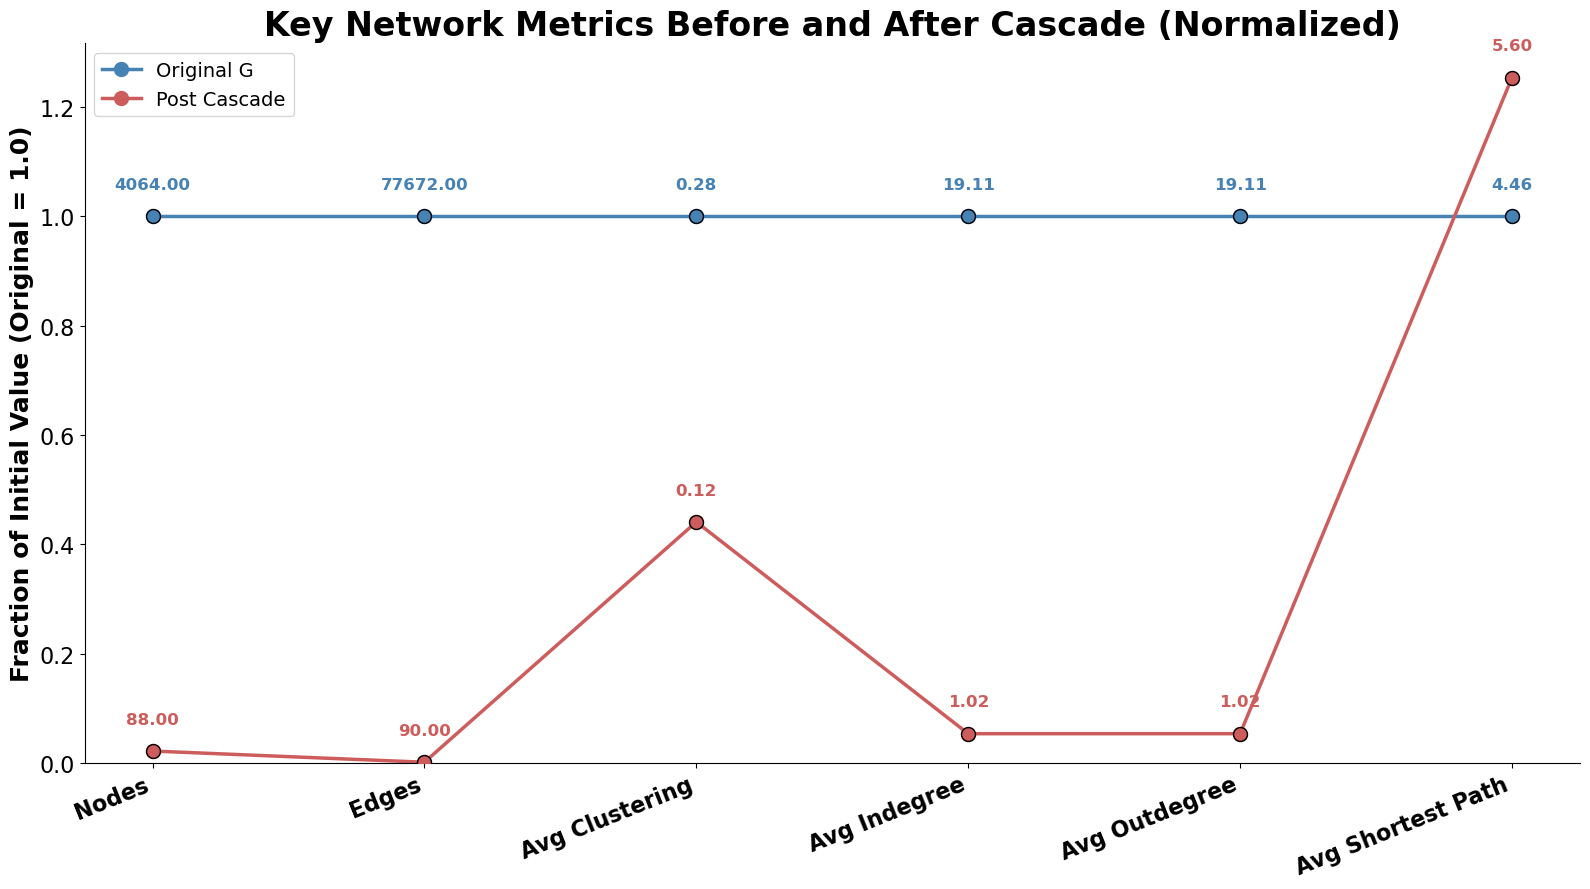

In [47]:
# Visualize impact on key network metrics before and after cascade

metrics = ['Nodes', 'Edges', 'Avg Clustering', 'Avg Indegree', 'Avg Outdegree', 'Avg Shortest Path']
original = [G.number_of_nodes(), G.number_of_edges(), full_net_avg_clustering, ind, outd, full_net_avg_shortest_path]
post = [G_post_cascade.number_of_nodes(), G_post_cascade.number_of_edges(), post_avg_clustering, post_avg_indegree, post_avg_outdegree, post_avg_shortest_path]

# Normalize so that "Original" is always 1.0 per metric
original_norm = np.ones(len(metrics))
post_norm = [p / o if o != 0 else 0 for p, o in zip(post, original)]

x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(16, 9))

# Line + point plot for Original G (always 1.0)
ax.plot(x, original_norm, marker='o', label='Original G', color='steelblue', linewidth=2.5, markersize=10)
# Line + point plot for Post Cascade (normalized)
ax.plot(x, post_norm, marker='o', label='Post Cascade', color='indianred', linewidth=2.5, markersize=10)

ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=22, ha='right', fontsize=16, weight=600)
ax.set_ylabel('Fraction of Initial Value (Original = 1.0)', fontsize=18, weight=600)
ax.set_ylim(bottom=0)
ax.set_title('Key Network Metrics Before and After Cascade (Normalized)', fontsize=24, weight=800, y=1)
ax.legend(loc='best', fontsize=14)
ax.tick_params(axis='y', labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate points with absolute values for clarity
for i, (o, p) in enumerate(zip(original_norm, post_norm)):
    ax.scatter(i, o, color='steelblue', s=100, edgecolor='black', zorder=5)
    ax.text(i, o+0.05, f'{original[i]:.2f}', ha='center', fontsize=12, weight=600, color='steelblue')
    ax.scatter(i, p, color='indianred', s=100, edgecolor='black', zorder=5)
    ax.text(i, p+0.05, f'{post[i]:.2f}', ha='center', fontsize=12, weight=600, color='indianred')

plt.tight_layout()
plt.show()

### Cascade Results - Findings

After simulating the cascade on the network, the following results were observed:

- **Nodes:** 4,064 → 88 (−97.8%)
- **Edges:** 77,672 → 90 (−99.9%)
- **Average Clustering:** 0.282 → 0.124 (−55.9%)
- **Average Indegree / Outdegree:** 19.11 → 1.02 (−94.7%)
- **Average Shortest Path Length:** 4.46 → 5.60 (+25.4%)

**Summary:**  
The dense network proved highly vulnerable to cascading failures. Triggering the top 10 central nodes destroyed nearly the entire structure — only 2.2% of nodes and 0.1% of edges survived. The surviving fragment is sparse, poorly clustered, and has longer path lengths, indicating complete loss of the original network's efficiency.

## Gephi Visualization

<img src="images/visualization.jpg" alt="Network Visualization" style="max-width: 900px;">

### Layout Parameters
![Layout Parameters](images/layout_parameters.jpg)

## Gephi Statistics

![Gephi Statistics](images/gephi_stats.jpg)